In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%R

######################################################
### PERFORM DIFFERENTIAL ANALYSIS (NPC48h vs mESC) ###
######################################################

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)
library(rtracklayer, lib = lib_)

### IMPORT COUNTS ###
count=read.csv("../INPUT_DATA/count_mESC-NPC48h.tsv", sep='\t', header = T, comment.char = '#')
rownames(count) = count$X
count$X = NULL
colnames(count) = c("mESC_DMSO_rep1","mESC_DMSO_rep2","mESC_DMSO_rep3",
                    "NPC48h_DMSO_2","NPC48h_DMSO_4","NPC48h_DMSO_5")


### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("mESC",3),rep("NPC48h",3)))

### CREATE DDS OBJECT ###
dds = DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ condition)

### ADD FEATURE DATA ### 
anno18 <- import.gff2("../../COMMON_REPOSITORY/gencode.vM18.annotation.sorted.gtf", feature.type = "gene")

featureData = data.frame(row.names = anno18$gene_id,
                         gene_name = anno18$gene_name,
                         gene_type = anno18$gene_type,
                         level = anno18$level,
                         chr = seqnames(anno18))

index = match(row.names(dds),row.names(featureData))
mcols(dds) = DataFrame(mcols(dds), featureData[index,])

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### SET REFERENCE LEVELS ###
dds$condition = relevel(dds$condition, ref = "mESC")

### CREATE RLOG TRANSFORMATION OF COUNT DATA ### 
rld = rlog(dds, blind=FALSE)
write.table(assay(rld), "../INTERMEDIATE_FILES/RLD_NPC48h_mESC.tsv", sep="\t", quote=F)


### DIFFERENTIAL EXPRESSION ANALYSIS ###
dds = DESeq(dds)

res = results(dds)
res_shrink = lfcShrink(dds, coef = "condition_NPC48h_vs_mESC", type="apeglm")
res_lfc_cutoff = results(dds, lfcThreshold=1, altHypothesis="greaterAbs")


res$symbol=mcols(dds)$gene_name
res_shrink$symbol=mcols(dds)$gene_name
res_lfc_cutoff$symbol=mcols(dds)$gene_name


### WRITE RESULTS TO FILE ###
resOrdered = as.data.frame(res[order(res$padj),])
write.table(resOrdered, 
            file = "../INTERMEDIATE_FILES/DE_genes_noLFCthr_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_shrink = as.data.frame(res_shrink[order(res_shrink$padj),])
write.table(resOrdered_shrink, 
            file = "../INTERMEDIATE_FILES/DE_genes_noLFCthr_shrinked_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_lfc = as.data.frame(res_lfc_cutoff[order(res_lfc_cutoff$padj),])
write.table(resOrdered_lfc, 
            file = "../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')



/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘pac

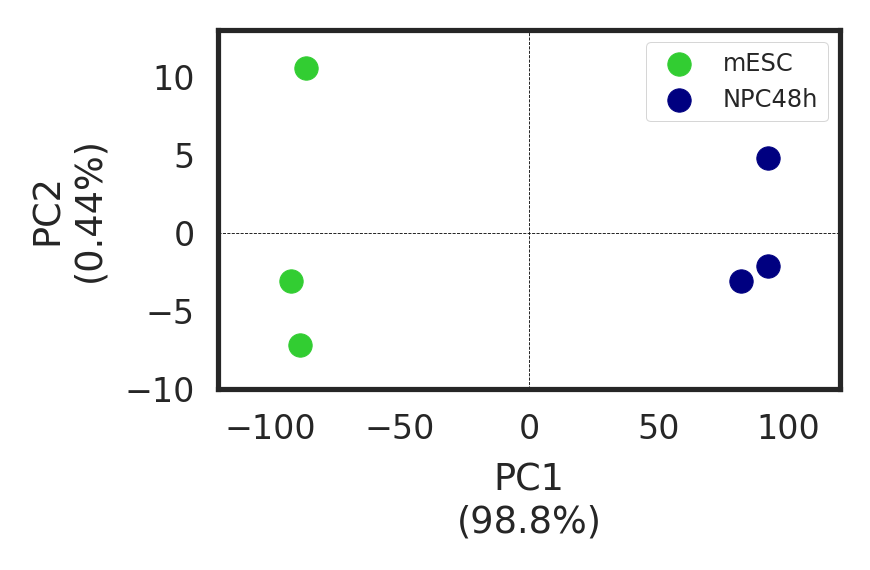

In [3]:
### IMPORT RLOG MATRIX ###
rlog = pd.read_csv("../INTERMEDIATE_FILES/RLD_NPC48h_mESC.tsv",sep="\t")
### select 500 most variable genes ###
top_var = rlog.var(axis=1).sort_values(ascending=False)[1:501].index
rlog = rlog.loc[top_var].T

### PERFORM PCA ###
pca = PCA()
pca_data = pca.fit_transform(rlog)

labels = ["PC{}".format(i) for i in range(pca_data.shape[1]+1)[1:]]
pca_df = pd.DataFrame(pca_data, index = ["mESC_1","mESC_2","mESC_3","NPC48h_1","NPC48h_2","NPC48h_3"], columns=labels)


### PLOT PCA ###
fig,ax=plt.subplots(dpi=300, figsize=(3,2))

plt.scatter(pca_df.filter(regex="^mESC", axis=0)["PC1"], pca_df.filter(regex="^mESC", axis=0)["PC2"], color="limegreen", label = "mESC")
plt.scatter(pca_df.filter(regex="^NPC", axis=0)["PC1"], pca_df.filter(regex="^NPC", axis=0)["PC2"], color="navy", label = "NPC48h")

ax.set_xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
ax.set_ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))

ax.set_ylim(-10,13)
ax.set_xlim(-120,120)

plt.axhline(0,linestyle="--",linewidth=0.2, color="k")
plt.axvline(0,linestyle="--",linewidth=0.2, color="k")

plt.legend(fontsize='xx-small', frameon=True)

plt.tight_layout()

plt.savefig("../FIGURES/PCA_mESC_NPC48h.pdf")
plt.savefig("../FIGURES/PCA_mESC_NPC48h.svg")

In [161]:
epigenes = pd.read_csv("../INPUT_DATA/EpiGenes_main.csv",sep=",")
#epigenes.loc[epigenes['Modification'].str.contains('Histone methylation|Histone acetylation')]
acetyltransferase=list(epigenes.loc[epigenes['Comment'].str.contains('acetyltransferase')]["MGI_symbol"].values)
deacetylase=list(epigenes.loc[epigenes['Comment'].str.contains('deacetylase')]["MGI_symbol"].values)
dot1l = list(epigenes.loc[epigenes["MGI_symbol"].str.contains('Dot1l')]["MGI_symbol"].values)

#epigenes = epigenes.loc[epigenes['Specific_target'].str.contains('H3Kac|H3K79')]["MGI_symbol"].values
#epigenes
epigenes = ['Hdac10','Hdac11','Hdac2', 'Hdac3', 'Hdac4', 'Hdac7', 'Hdac8', 'Hdac9','Hdac5','Sin3a', 'Hdac6','Sin3b','Sirt2', 'Sirt6', 'Dot1l',
           'Ep300','Hat1', 'Kat2b', 'Kat6a', 'Kat6b', 'Kat7','Kat8','Taf1', 'Taf5', 'Taf7']

In [162]:
# acetyltransferase=list(epigenes.loc[epigenes['Modification'].str.contains('Histone acetylation')]["MGI_symbol"].values)
# deacetylase=list(epigenes.loc[epigenes['Modification'].str.contains('Histone deacetylation')]["MGI_symbol"].values)
# dot1l = list(epigenes.loc[epigenes["MGI_symbol"].str.contains('Dot1l')]["MGI_symbol"].values)
# epigenes = pd.DataFrame({"symbol" : acetyltransferase + deacetylase + dot1l, "classification" : ['HAT']*len(acetyltransferase) + ['HDAC']*len(deacetylase) + ["DOT1L"]})



In [40]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")

from adjustText import adjust_text

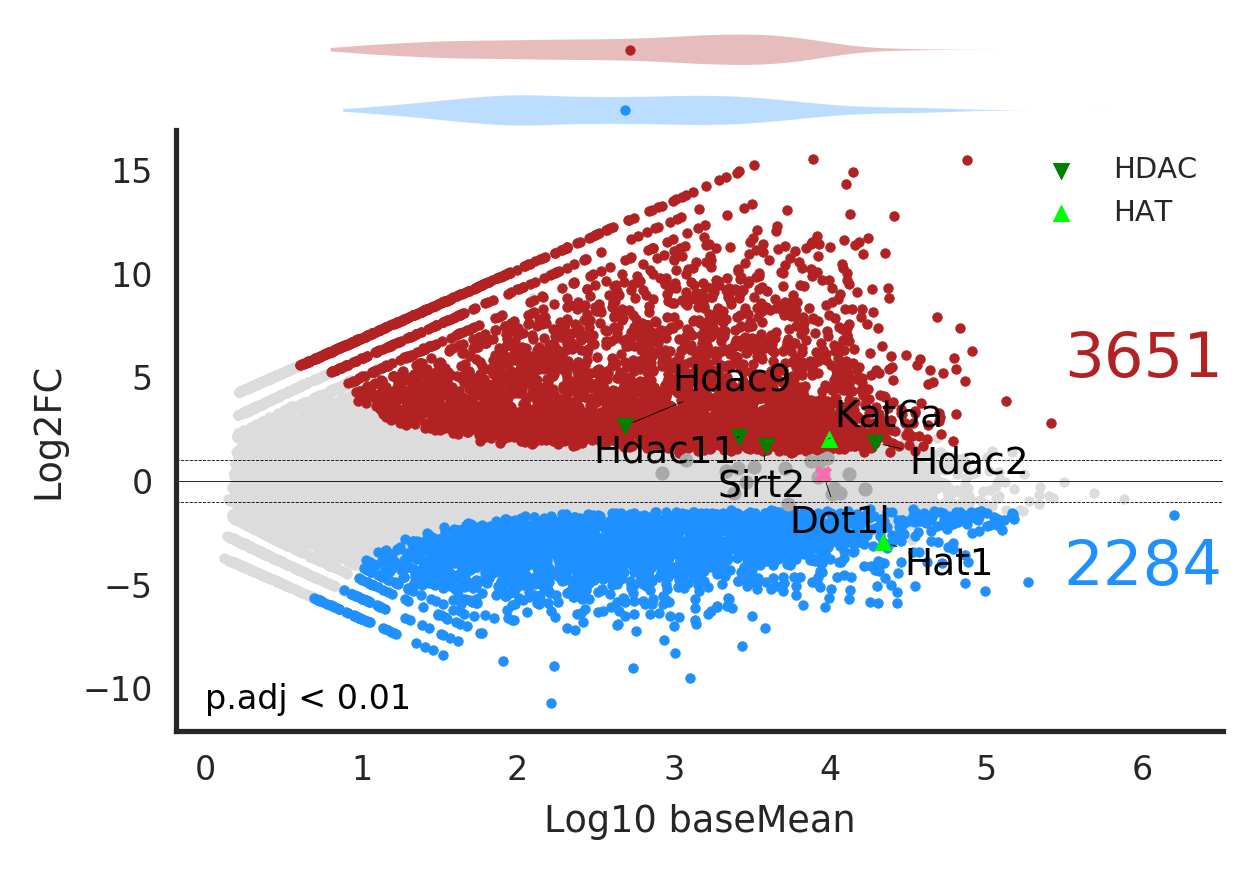

In [165]:
npc = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv", sep="\t")
epi_npc = npc.loc[[i in epigenes for i in npc.symbol]].sort_values(by=["pvalue"], ascending=True)
epi_npc["classification"] = ["HAT"]*2+["HDAC"]*5+["HAT","HDAC","DOT1L",'HAT','HDAC','HAT']+['HDAC']*4+["HAT"]*2+["HDAC"]*2+["HAT"]*3+["HDAC"]
epi_npc
pval_thr = 0.01

up = (npc.padj <pval_thr) & (npc.log2FoldChange > 0)
down = (npc.padj <pval_thr) & (npc.log2FoldChange < 0)

fig,ax = plt.subplots(2,1,dpi=300,figsize=(4.3,3), gridspec_kw={'height_ratios': [1, 6], "hspace":0})

ax[0].axis('off')
ax[0].set_xlim((-0.5,7))
cols=['dodgerblue','firebrick']
vp = ax[0].violinplot([np.log10(npc.baseMean.loc[down]), np.log10(npc.baseMean.loc[up])],[0,1], 
                      vert=False, showextrema=False, showmedians=False)
ax[0].scatter(np.mean(np.log10(npc.baseMean.loc[down])),[0], color='dodgerblue',s=5)
ax[0].scatter(np.mean(np.log10(npc.baseMean.loc[up])),[1], color='firebrick',s=5)

for i in range(len(vp['bodies'])):
    vp['bodies'][i].set_facecolor(cols[i])

    
ax[1].scatter(np.log10(npc.baseMean),npc.log2FoldChange,color="gainsboro", s=5)
ax[1].scatter(np.log10(npc.baseMean.loc[up]),npc.log2FoldChange.loc[up],color="firebrick", s=5)
ax[1].scatter(np.log10(npc.baseMean.loc[down]),npc.log2FoldChange.loc[down],color="dodgerblue", s=5)
ax[1].annotate(sum(up), (5.5,5), color="firebrick", size=15)
ax[1].annotate(sum(down), (5.5,-5), color="dodgerblue", size=15)
ax[1].annotate("p.adj < {}".format(pval_thr), (0,-11), color="k", size=8)
ax[1].axhline(0,linewidth=0.2,linestyle='-', color='k')
ax[1].axhline(1,linewidth=0.2,linestyle='--', color='k')
ax[1].axhline(-1,linewidth=0.2,linestyle='--', color='k')
# ax[1].set_ylim((-1.5,1.5))
# ax[1].set_xlim((-0.5,7))
ax[1].set_ylabel("Log2FC")
ax[1].set_xlabel("Log10 baseMean")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)


ax[0].axis('off')

ax[1].scatter(np.log10(epi_npc.baseMean.loc[(epi_npc.padj>0.05)]),epi_npc.log2FoldChange.loc[epi_npc.padj>0.05],color="darkgrey", s=10)
ax[1].scatter(np.log10(epi_npc.baseMean.loc[(epi_npc.padj<0.05)&(epi_npc.classification=="HDAC")]),epi_npc.log2FoldChange.loc[(epi_npc.padj<0.05)&(epi_npc.classification=="HDAC")], color="green", s=15, marker="v", label = "HDAC")
ax[1].scatter(np.log10(epi_npc.baseMean.loc[(epi_npc.padj<0.05)&(epi_npc.classification=="HAT")]),epi_npc.log2FoldChange.loc[(epi_npc.padj<0.05)&(epi_npc.classification=="HAT")], color="lime", s=15, marker="^", label = "HAT")
ax[1].scatter(np.log10(epi_npc.baseMean.loc[(epi_npc.classification=="DOT1L")]),epi_npc.log2FoldChange.loc[(epi_npc.classification=="DOT1L")], color="hotpink", s=10, marker="x")



epi_npc = epi_npc.loc[(epi_npc.padj<0.05) | (epi_npc.classification=="DOT1L")]
texts = [plt.text(np.log10(epi_npc.baseMean).values[i], epi_npc.log2FoldChange.values[i], "{}".format(epi_npc[["symbol"]].values[i][0]), ha='center', va='center', color="k", fontsize=9) for i in range(epi_npc.shape[0])]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.2))
plt.legend(fontsize="x-small")

plt.tight_layout()

plt.savefig("../FIGURES/MA_plot_NPC48hvsESC_shrinked.png")